# Imports and inits

In [5]:
import pandas as pd
import numpy as np
import os
import neurokit2 as nk
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
import statsmodels.api as sm
import gc
%matplotlib inline

In [6]:
plt.rcParams['figure.figsize'] = [20, 8]  # Bigger images

In [52]:
folder_path = "/Users/annapalatkina/Desktop/drive/participants"  

data_full = pd.DataFrame(columns=['Row', 'Timestamp', 'EDA', 'ECG', 'EventLabel', 'Participant'])


for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)  
    if filename.endswith('.csv'): 
        data = pd.read_csv(file_path, comment='#',low_memory=False)
        if 'Channel 9 (EDA100C)' in data.columns:
            eda_column = 'Channel 9 (EDA100C)'
            ecg_column = 'Channel 13 (ECG100C)'
        elif 'Channel 9 (Raw)' in data.columns:
            eda_column = 'Channel 9 (Raw)'
            ecg_column = 'Channel 13 (Raw)'
        data = data[['Row', 'Timestamp', eda_column, ecg_column,'MarkerName','MarkerType']]
        start, end = data.query('MarkerName == "Experiment" and MarkerType == "S"').index.values[0], data.query('MarkerName == "Experiment" and MarkerType == "E"').index.values[0]
        data = data[start:end+1]
        data.reset_index(inplace=True, drop=True)
        markers =  list(data[data['MarkerName'].notna()].sort_values('Row').MarkerName.unique())
        markers.remove('Experiment')
        data['EventLabel'] = pd.Series(dtype='object')
        for i,m in enumerate(markers):
            start = data[(data.MarkerName == m) & (data.MarkerType == "S")].index.values[0]
            end = data[(data.MarkerName == m) & (data.MarkerType == "E")].index.values[0]
            data.loc[start:end, 'EventLabel'] = data.loc[start:end, 'EventLabel'].fillna(m)
        #data['EventLabel'] = data['EventLabel'].fillna('Silence')

        non_nan_indices = data['EventLabel'].notna()
        first_non_nan = non_nan_indices.idxmax() 
        last_non_nan = non_nan_indices[::-1].idxmax()

        data.loc[:first_non_nan-1, 'EventLabel'] = data.loc[:first_non_nan-1, 'EventLabel'].fillna('first_silence')
        data.loc[last_non_nan+1:, 'EventLabel'] = data.loc[last_non_nan+1:, 'EventLabel'].fillna('last_silence')

        data.dropna(subset=[eda_column, ecg_column], inplace=True)
        data.drop(columns=['MarkerName', 'MarkerType'], inplace=True)
        data['Participant'] = [filename.split('.')[0]] * len(data)
        data.rename(columns={eda_column: 'EDA', ecg_column:'ECG'}, inplace=True)
        data_full = pd.concat([data_full, data], ignore_index=True)
        del data
        gc.collect()
 

data_full

/var/folders/f1/w7d0x47j0qq9jn7k7vhjrkzh0000gn/T/ipykernel_8598/4059593880.py:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_full = pd.concat([data_full, data], ignore_index=True)


,Row,Timestamp,EDA,ECG,EventLabel,Participant
0,4507,10545.0005,1.191406,0.973206,first_silence,I8L4N6G7
1,4508,10550.0005,1.192017,1.372375,first_silence,I8L4N6G7
2,4509,10555.0005,1.191711,1.466064,first_silence,I8L4N6G7
3,4514,10560.0005,1.192322,1.022949,first_silence,I8L4N6G7
4,4515,10565.0005,1.192322,0.177612,first_silence,I8L4N6G7
...,...,...,...,...,...,...
3230932,397469,933564.2909,1.839600,-0.037537,last_silence,K4G7Y9O2
3230933,397471,933569.2909,1.841431,-0.045776,last_silence,K4G7Y9O2
3230934,397472,933574.2909,1.839905,-0.041504,last_silence,K4G7Y9O2
3230935,397473,933579.2909,1.840210,-0.043945,last_silence,K4G7Y9O2


In [53]:
data_full.Participant.value_counts()

Participant
V9L0P2K7    180004
N7P5B8G0    180002
J6W7Q4H5    180001
G9K4W1Z0    180000
Z6A2W1E8    180000
M4H6R2W9    180000
X5Q0G4J2    180000
J4X1T0D2    180000
C1K4L9S8    179999
D0P7X9W6    179997
M7D3F5K4    179997
O4A0U8R1    179997
G2Y7J4Q1    179997
K4G7Y9O2    179996
L0S1Z2I3    179994
U6O5V2T9    178371
I8L4N6G7    178046
M0R6U5F9    174536
Name: count, dtype: int64

In [54]:
data_full.EventLabel.value_counts() 

EventLabel
IntenseAudio     979597
CalmAudio        977847
first_silence    752936
last_silence     340336
InterimAudio     180221
Name: count, dtype: int64

In [55]:
sampling_rate = 200

In [57]:
mask_silence_first = (data_full["EventLabel"] == "first_silence")
mask_silence_last = (data_full["EventLabel"] == "last_silence")
mask_negative = (data_full["EventLabel"] == "IntenseAudio")
mask_positive = (data_full["EventLabel"] == "CalmAudio")
mask_music = (data_full["EventLabel"] == "InterimAudio")

In [58]:
positives = data_full[mask_positive]
negatives = data_full[mask_negative]
baselines_first = data_full[mask_silence_first]
baselines_last = data_full[mask_silence_last]

## Some checks if we the have right conditions markers

In [ ]:
folder_path = "/Users/annapalatkina/Desktop/drive/participants"  

data_full = pd.DataFrame(columns=['Row', 'Timestamp', 'EDA', 'ECG', 'EventLabel', 'Participant'])


for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)  
    if filename.endswith('.csv'): 
        data = pd.read_csv(file_path, comment='#',low_memory=False)
        if 'Channel 9 (EDA100C)' in data.columns:
            eda_column = 'Channel 9 (EDA100C)'
            ecg_column = 'Channel 13 (ECG100C)'
        elif 'Channel 9 (Raw)' in data.columns:
            eda_column = 'Channel 9 (Raw)'
            ecg_column = 'Channel 13 (Raw)'
        data = data[['Row', 'Timestamp', eda_column, ecg_column,'MarkerName','MarkerType']]
        start, end = data.query('MarkerName == "Experiment" and MarkerType == "S"').index.values[0], data.query('MarkerName == "Experiment" and MarkerType == "E"').index.values[0]
        data = data[start:end+1]
        data.reset_index(inplace=True, drop=True)
        markers =  list(data[data['MarkerName'].notna()].sort_values('Row').MarkerName.unique())
        markers.remove('Experiment')
        data['EventLabel'] = pd.Series(dtype='object')
        for i,m in enumerate(markers):
            start = data[(data.MarkerName == m) & (data.MarkerType == "S")].index.values[0]
            end = data[(data.MarkerName == m) & (data.MarkerType == "E")].index.values[0]
            data.loc[start:end, 'EventLabel'] = data.loc[start:end, 'EventLabel'].fillna(m)
        #data['EventLabel'] = data['EventLabel'].fillna('Silence')

        non_nan_indices = data['EventLabel'].notna()
        first_non_nan = non_nan_indices.idxmax() 
        last_non_nan = non_nan_indices[::-1].idxmax()

        data.loc[:first_non_nan-1, 'EventLabel'] = data.loc[:first_non_nan-1, 'EventLabel'].fillna('first_silence')
        data.loc[last_non_nan+1:, 'EventLabel'] = data.loc[last_non_nan+1:, 'EventLabel'].fillna('last_silence')

        #data.dropna(subset=[eda_column, ecg_column], inplace=True)
        #data.drop(columns=['MarkerName', 'MarkerType'], inplace=True)
        data['Participant'] = [filename.split('.')[0]] * len(data)
        data.rename(columns={eda_column: 'EDA', ecg_column:'ECG'}, inplace=True)
        data_full = pd.concat([data_full, data], ignore_index=True)
        del data
        gc.collect()
 
  
data_full

In [35]:
df = data_full.query('Participant == "I8L4N6G7"')
df

,Row,Timestamp,EDA,ECG,EventLabel,Participant,MarkerName,MarkerType
0,4505,10541.8497,NaN,NaN,first_silence,I8L4N6G7,Experiment,S
1,4506,10543.3591,NaN,NaN,first_silence,I8L4N6G7,NaN,NaN
2,4507,10545.0005,1.191406,0.973206,first_silence,I8L4N6G7,NaN,NaN
3,4508,10550.0005,1.192017,1.372375,first_silence,I8L4N6G7,NaN,NaN
4,4509,10555.0005,1.191711,1.466064,first_silence,I8L4N6G7,NaN,NaN
...,...,...,...,...,...,...,...,...
369289,373794,900758.7578,NaN,NaN,last_silence,I8L4N6G7,NaN,NaN
369290,373795,900760.0005,0.632019,-0.231934,last_silence,I8L4N6G7,NaN,NaN
369291,373796,900765.0005,0.631409,-0.271912,last_silence,I8L4N6G7,NaN,NaN
369292,373797,900770.0005,0.631714,-0.273438,last_silence,I8L4N6G7,NaN,NaN


In [36]:
df[df['MarkerName'].notna()]

,Row,Timestamp,EDA,ECG,EventLabel,Participant,MarkerName,MarkerType
0,4505,10541.8497,NaN,NaN,first_silence,I8L4N6G7,Experiment,S
85327,89832,210921.5506,NaN,NaN,CalmAudio,I8L4N6G7,CalmAudio,S
198584,203089,483014.3602,NaN,NaN,CalmAudio,I8L4N6G7,InterimAudio,S
198585,203090,483014.3602,NaN,NaN,CalmAudio,I8L4N6G7,CalmAudio,E
219301,223806,532895.4630,NaN,NaN,InterimAudio,I8L4N6G7,IntenseAudio,S
219302,223807,532895.4630,NaN,NaN,InterimAudio,I8L4N6G7,InterimAudio,E
331477,335982,805396.7579,NaN,NaN,IntenseAudio,I8L4N6G7,IntenseAudio,E
369293,373798,900774.3035,NaN,NaN,last_silence,I8L4N6G7,Experiment,E


In [39]:
df.query('210921.5506 > Timestamp >= 10541.8497	').EventLabel.value_counts()

EventLabel
first_silence    85327
Name: count, dtype: int64

In [42]:
df.query('532895.4630 > Timestamp >= 483014.3602').EventLabel.value_counts()

EventLabel
InterimAudio    20715
CalmAudio           2
Name: count, dtype: int64

# ECG

## Quality check

In [23]:
def get_rmssd_per_segment(ecg_data_raw, segment_duration):
    
    ecg = nk.ecg_clean(ecg_data_raw, sampling_rate=sampling_rate)
    peaks, info = nk.ecg_peaks(ecg, sampling_rate=sampling_rate)
    r_peaks = info['ECG_R_Peaks']
    #segment_duration = 60  # For 1-minute segments (use 30 for 30-second segments)

    # Step 1: Convert R-peak indices to time (seconds)
    times = np.array(r_peaks) / sampling_rate

    # Step 2: Calculate RR intervals (in milliseconds)
    rr_intervals = np.diff(times) * 1000  # Difference in seconds, then convert to ms

    # Step 3: Segment the data
    total_duration = times[-1]  # Total experiment time in seconds
    num_segments = int(np.floor(total_duration / segment_duration))
    # print(total_duration, num_segments)

    rmssd_per_segment = []
    time_list = []

    for seg in range(num_segments):
        # Define the time window for this segment
        start_time = seg * segment_duration
        end_time = (seg + 1) * segment_duration
        
        # Find R-peaks within this time window
        mask = (times[:-1] >= start_time) & (times[:-1] < end_time)
        segment_rr = rr_intervals[mask]
        
        # Step 4: Calculate RMSSD for this segment
        successive_diffs = np.diff(segment_rr)
        squared_diffs = successive_diffs ** 2
        mean_squared_diffs = np.mean(squared_diffs)
        rmssd = np.sqrt(mean_squared_diffs)
        rmssd_per_segment.append(rmssd)
        time_list.append(end_time)
    
    # print(len(time_list), len(rmssd_per_segment))
    rmssd_df = pd.DataFrame({'Time': time_list, 'RMSSD': rmssd_per_segment})
    rmssd_df['Time_str'] = rmssd_df['Time'].apply(lambda x: str(timedelta(seconds=x)))

    return rmssd_df

In [10]:
participant = data_full.query('Participant ==  "C1K4L9S8"')
participant

,Row,Timestamp,EDA,ECG,EventLabel,Participant
2870939,1609,5139.4775,1.437073,-0.871582,first_silence,C1K4L9S8
2870940,1610,5144.4775,1.437073,-0.826111,first_silence,C1K4L9S8
2870941,1611,5149.4775,1.436768,-0.754395,first_silence,C1K4L9S8
2870942,1612,5154.4775,1.437073,-0.677185,first_silence,C1K4L9S8
2870943,1614,5159.4775,1.437378,-0.617676,first_silence,C1K4L9S8
...,...,...,...,...,...,...
3050933,348622,905109.4775,1.686707,-0.785217,last_silence,C1K4L9S8
3050934,348623,905114.4775,1.686401,-0.759583,last_silence,C1K4L9S8
3050935,348624,905119.4775,1.685791,-0.717163,last_silence,C1K4L9S8
3050936,348625,905124.4775,1.686096,-0.657349,last_silence,C1K4L9S8


The normal range for the R-R interval on an electrocardiogram (ECG) is typically between 0.6 to 1.2 seconds (600-1200ms)

   HRV_RMSSD  HRV_MeanNN   HRV_SDNN  HRV_pNN50
0  29.542751  974.983731  52.322548   4.989154


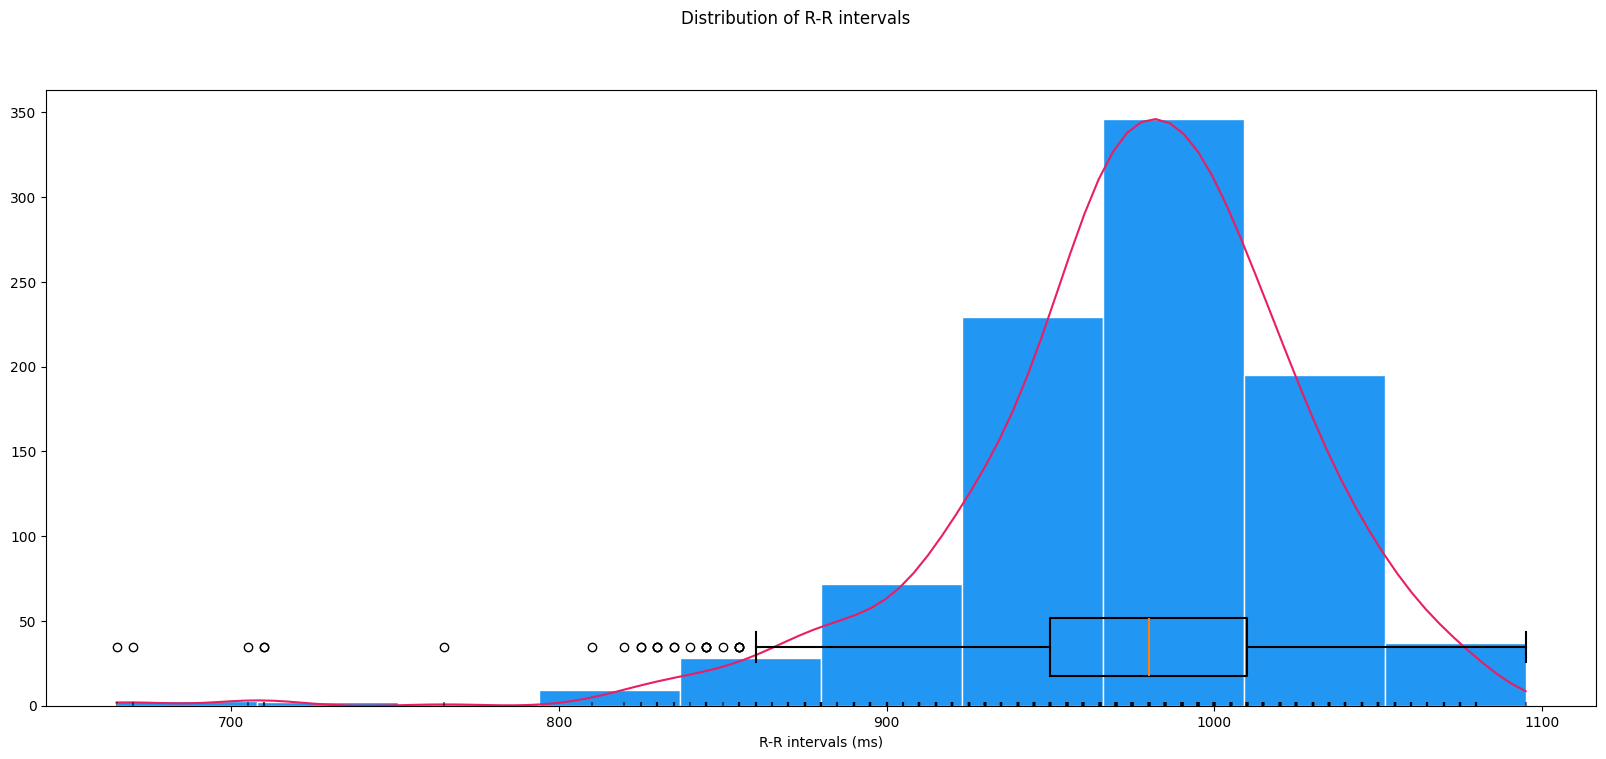

In [11]:
# Get HRV features over full signal
ecg_cleaned = nk.ecg_clean(participant["ECG"], sampling_rate=sampling_rate)
peaks, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate, correct_artifacts=True)

hrv = nk.hrv_time(peaks, sampling_rate=sampling_rate, show=True)
print(hrv[['HRV_RMSSD', 'HRV_MeanNN', 'HRV_SDNN', 'HRV_pNN50']])

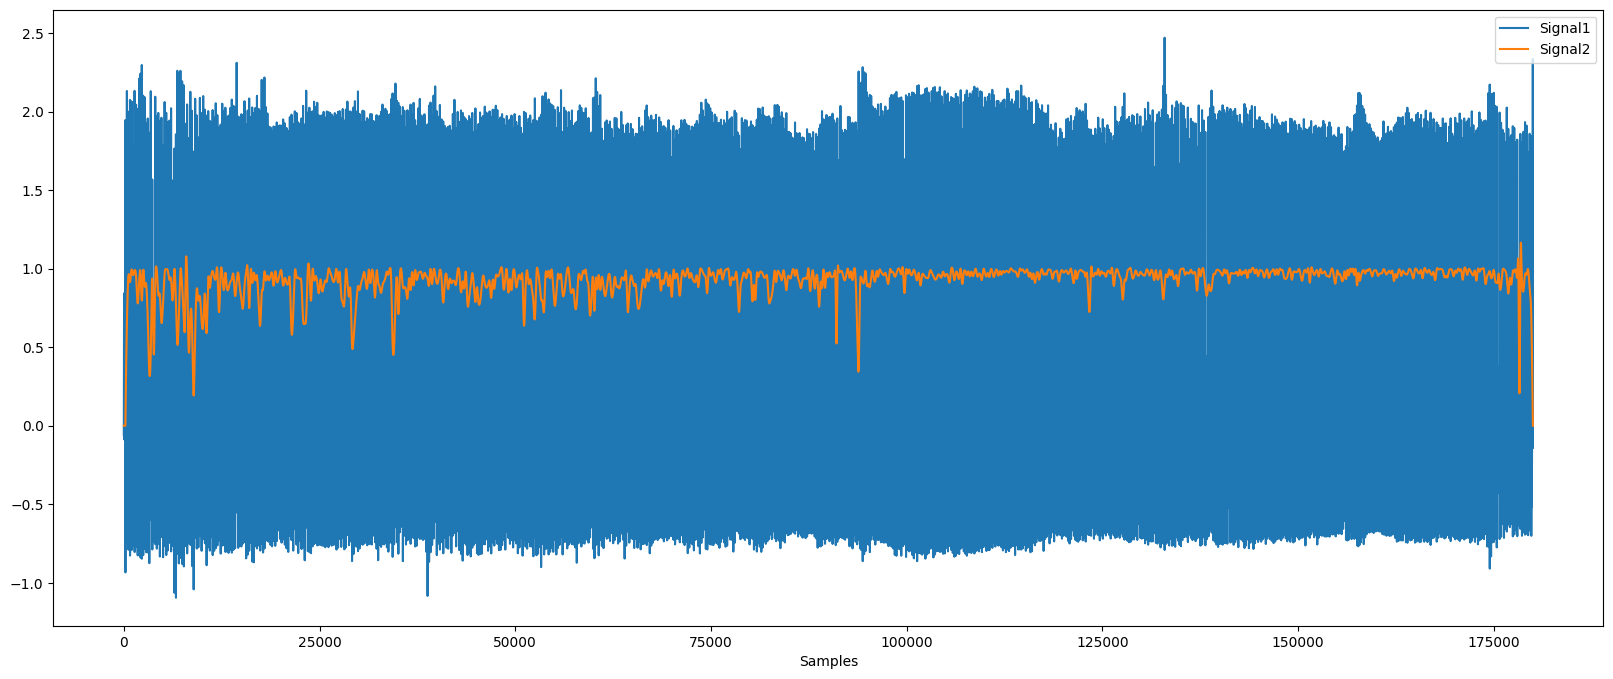

In [12]:
quality = nk.ecg_quality(ecg_cleaned, sampling_rate=sampling_rate)
nk.signal_plot([ecg_cleaned, quality])

In [13]:
min(quality), max(quality), np.mean(quality)

(np.float64(0.0),
 np.float64(1.1651444675292115),
 np.float64(0.9248669944984322))

In [14]:
import numpy as np
import scipy.stats as stats

# Assuming `quality` is your array of averageQRS values
mean_quality = np.mean(quality)
std_quality = np.std(quality)
n = len(quality)

# 95% Confidence Interval for the mean
ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=mean_quality, scale=std_quality / np.sqrt(n))

# Proportion below quality threshold
low_quality_pct = np.sum(quality < 0.8) / n * 100

print(f"Mean quality: {mean_quality:.3f}")
print(f"95% CI: [{ci_low:.4f}, {ci_high:.4f}]")
print(f"Std deviation: {std_quality:.3f}")
print(f"Percent below 0.8: {low_quality_pct:.2f}%")


Mean quality: 0.925
95% CI: [0.9244, 0.9253]
Std deviation: 0.098
Percent below 0.8: 7.54%


To ensure the reliability of ECG data used in heart rate variability (HRV) analysis, we conducted a beat-wise signal quality assessment using the ecg_quality() function from the NeuroKit2 library. For each participant, raw ECG signals were first preprocessed using ecg_clean() to remove baseline wander and high-frequency noise. We then applied the "averageQRS" method, which computes a continuous quality index based on the similarity of each QRS complex to the average beat morphology. For each participant, we calculated the mean signal quality score and the corresponding 95% confidence interval using the standard error of the mean. Participants with lower bounds of the confidence interval above 0.8 were considered to have high-quality ECG data suitable for HRV analysis. A summary plot of mean quality scores with confidence intervals was generated to visualize the consistency of signal quality across participants.


The "averageQRS" method computes a beat-by-beat quality index by comparing each QRS complex in the ECG signal to the average QRS shape derived from the same recording. This participant-specific, relative comparison ensures that beats deviating significantly from the overall morphology are assigned lower quality scores. While it effectively captures local noise and outliers, it assumes that the majority of beats are representative of true cardiac activity and may overestimate quality if the entire signal is degraded.

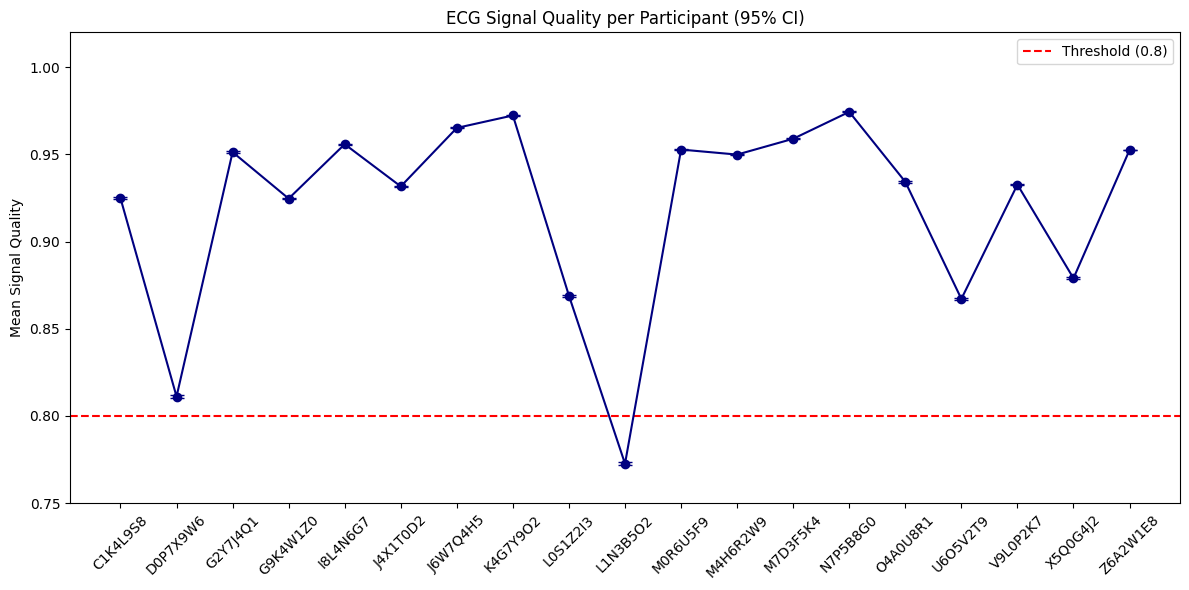

In [15]:
import pandas as pd
import numpy as np
import neurokit2 as nk
import matplotlib.pyplot as plt
import scipy.stats as stats

# Placeholder for results
results = []

# Loop through each participant
for participant_id, group in data_full.groupby("Participant"):
    ecg = group["ECG"].values.flatten()  # adjust as needed for your structure
    
    # Clean ECG signal
    ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=sampling_rate)

    # Compute quality vector
    quality = nk.ecg_quality(ecg_cleaned, sampling_rate=sampling_rate)

    # Compute summary stats
    mean_q = np.mean(quality)
    std_q = np.std(quality)
    n = len(quality)

    # Confidence interval (95%)
    ci_low, ci_high = stats.t.interval(0.95, df=n-1, loc=mean_q, scale=std_q / np.sqrt(n))

    results.append({
        "Participant": participant_id,
        "Mean_Quality": mean_q,
        "CI_Lower": mean_q - ci_low,  # distance to lower bound
        "CI_Upper": ci_high - mean_q  # distance to upper bound
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by participant ID
results_df = results_df.sort_values("Participant")

# Plot
plt.figure(figsize=(12, 6))
plt.errorbar(
    x=results_df["Participant"],
    y=results_df["Mean_Quality"],
    yerr=[results_df["CI_Lower"], results_df["CI_Upper"]],
    fmt='o-', capsize=5, markersize=6, color='navy'
)

plt.axhline(0.8, linestyle='--', color='red', label='Threshold (0.8)')
plt.xticks(rotation=45)
plt.ylim(0.75, 1.02)
plt.ylabel("Mean Signal Quality")
plt.title("ECG Signal Quality per Participant (95% CI)")
plt.legend()
plt.tight_layout()
plt.show()


In [16]:
results_df

,Participant,Mean_Quality,CI_Lower,CI_Upper
0,C1K4L9S8,0.924867,0.000453,0.000453
1,D0P7X9W6,0.811121,0.000653,0.000653
2,G2Y7J4Q1,0.951309,0.000430,0.000430
3,G9K4W1Z0,0.924648,0.000372,0.000372
4,I8L4N6G7,0.955837,0.000283,0.000283
5,J4X1T0D2,0.931628,0.000505,0.000505
6,J6W7Q4H5,0.965179,0.000285,0.000285
7,K4G7Y9O2,0.972330,0.000293,0.000293
8,L0S1Z2I3,0.868948,0.000602,0.000602
9,L1N3B5O2,0.772594,0.000940,0.000940


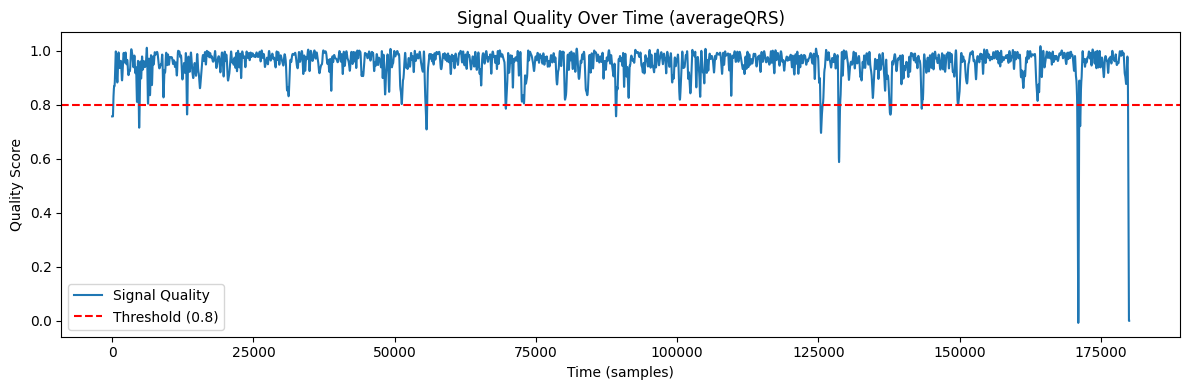

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(quality, label="Signal Quality")
plt.axhline(0.8, color="red", linestyle="--", label="Threshold (0.8)")
plt.title("Signal Quality Over Time (averageQRS)")
plt.xlabel("Time (samples)")
plt.ylabel("Quality Score")
plt.legend()
plt.tight_layout()
plt.show()


In [117]:
# Another approach of quality measurements

In [20]:
# Loop through each participant
q = []
for participant_id, group in data_full.groupby("Participant"):
    ecg = group["ECG"].values.flatten()  # adjust as needed for your structure
    
    # Clean ECG signal
    ecg_cleaned = nk.ecg_clean(ecg, sampling_rate=sampling_rate)

    quality = nk.ecg_quality(ecg_cleaned,sampling_rate=sampling_rate, method="zhao2018", approach="fuzzy")
    q.append(quality)
    print(participant_id, quality)



C1K4L9S8 Excellent
D0P7X9W6 Excellent
G2Y7J4Q1 Excellent
G9K4W1Z0 Excellent
I8L4N6G7 Excellent
J4X1T0D2 Excellent
J6W7Q4H5 Excellent
K4G7Y9O2 Excellent
L0S1Z2I3 Excellent
L1N3B5O2 Excellent
M0R6U5F9 Excellent
M4H6R2W9 Excellent
M7D3F5K4 Barely acceptable
N7P5B8G0 Excellent
O4A0U8R1 Barely acceptable
U6O5V2T9 Excellent
V9L0P2K7 Excellent
X5Q0G4J2 Excellent
Z6A2W1E8 Excellent


In [105]:
nk.ecg_quality(ecg_cleaned,
               sampling_rate=sampling_rate,
               method="zhao2018",
               approach="fuzzy")

'Excellent'

In [ ]:
segment_duration = 30


participand_rmssd_segments = get_rmssd_per_segment(participant.ECG, segment_duration)
participand_rmssd_segments

,Time,RMSSD,Time_str
0,30,30.639731,0:00:30
1,60,163.352890,0:01:00
2,90,36.258174,0:01:30
3,120,17.853571,0:02:00
4,150,20.489695,0:02:30
5,180,19.514952,0:03:00
6,210,22.360680,0:03:30
7,240,24.670239,0:04:00
8,270,26.294093,0:04:30
9,300,31.118055,0:05:00


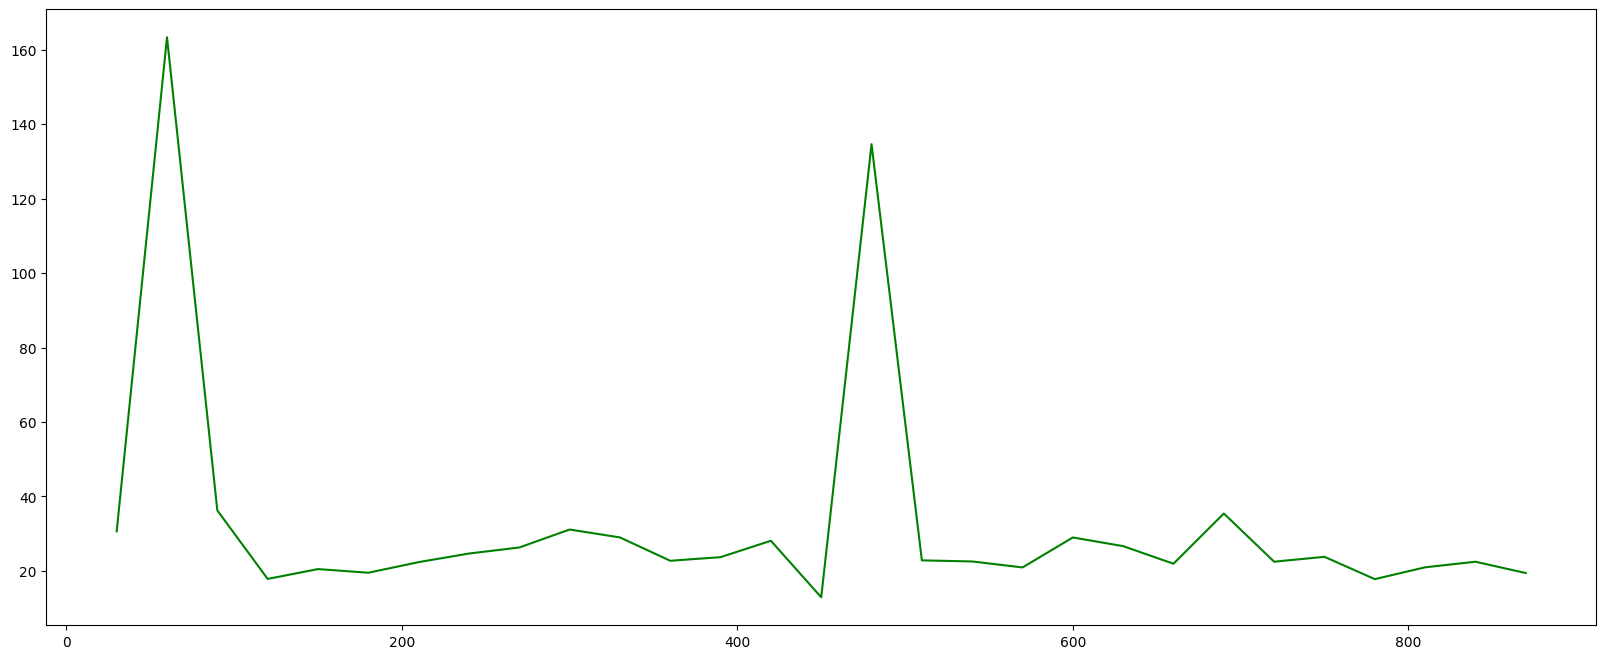

In [25]:
plt.plot(participand_rmssd_segments.Time, participand_rmssd_segments.RMSSD, 'g') 
plt.show()

## Stat tests

In [59]:
def get_slope_for_condition(ecg_data_raw, segment_duration):
    
    ecg = nk.ecg_clean(ecg_data_raw, sampling_rate=sampling_rate)
    peaks, info = nk.ecg_peaks(ecg, sampling_rate=sampling_rate)
    r_peaks = info['ECG_R_Peaks']
    #segment_duration = 60  # For 1-minute segments (use 30 for 30-second segments)

    # Step 1: Convert R-peak indices to time (seconds)
    times = np.array(r_peaks) / sampling_rate

    # Step 2: Calculate RR intervals (in milliseconds)
    rr_intervals = np.diff(times) * 1000  # Difference in seconds, then convert to ms

    # Step 3: Segment the data
    total_duration = times[-1]  # Total experiment time in seconds
    num_segments = int(np.floor(total_duration / segment_duration))
    # print(total_duration, num_segments)

    rmssd_per_segment = []
    time_list = []

    for seg in range(num_segments):
        # Define the time window for this segment
        start_time = seg * segment_duration
        end_time = (seg + 1) * segment_duration
        
        # Find R-peaks within this time window
        mask = (times[:-1] >= start_time) & (times[:-1] < end_time)
        segment_rr = rr_intervals[mask]
        
        # Step 4: Calculate RMSSD for this segment
        successive_diffs = np.diff(segment_rr)
        squared_diffs = successive_diffs ** 2
        mean_squared_diffs = np.mean(squared_diffs)
        rmssd = np.sqrt(mean_squared_diffs)
        rmssd_per_segment.append(rmssd)
        time_list.append(end_time)
    
    # print(len(time_list), len(rmssd_per_segment))
    #rmssd_df = pd.DataFrame({'Time': time_list, 'RMSSD': rmssd_per_segment})
    #rmssd_df['Time_str'] = rmssd_df['Time'].apply(lambda x: str(timedelta(seconds=x)))

    X = sm.add_constant(time_list)
    model = sm.OLS(rmssd_per_segment, X).fit()
    slope = model.params[1]

    return slope

In [61]:
segment_duration = 30


positives_slopes = [get_slope_for_condition(data.ECG, segment_duration) for participant_id, data in positives.groupby(by='Participant')]
negatives_slopes = [get_slope_for_condition(data.ECG, segment_duration) for participant_id, data in negatives.groupby(by='Participant')]
baselines_slopes_fisrt = [get_slope_for_condition(data.ECG, segment_duration) for participant_id, data in baselines_first.groupby(by='Participant')]
baselines_slopes_last = [get_slope_for_condition(data.ECG, segment_duration) for participant_id, data in baselines_last.groupby(by='Participant')]

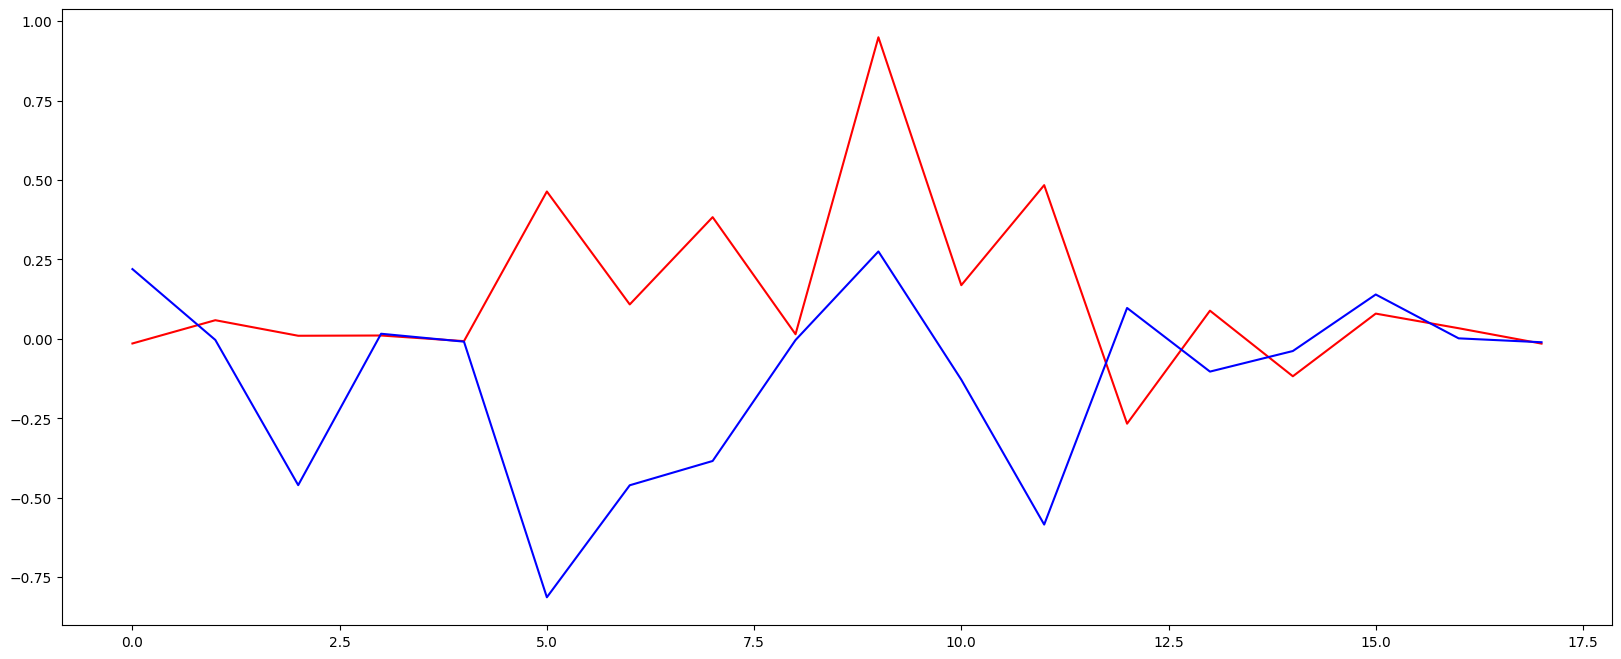

In [66]:
from numpy import *
import math
import matplotlib.pyplot as plt
t = [i for i in range(len(positives_slopes))]

plt.plot(t,positives_slopes, 'r') # plotting t, a separately 
plt.plot(t,negatives_slopes, 'b') # plotting t, b separately 
#plt.plot(t,baselines_slopes_fisrt, 'g') # plotting t, c separately 
#plt.plot(t,baselines_slopes_last, 'y') # plotting t, c separately 
plt.show()

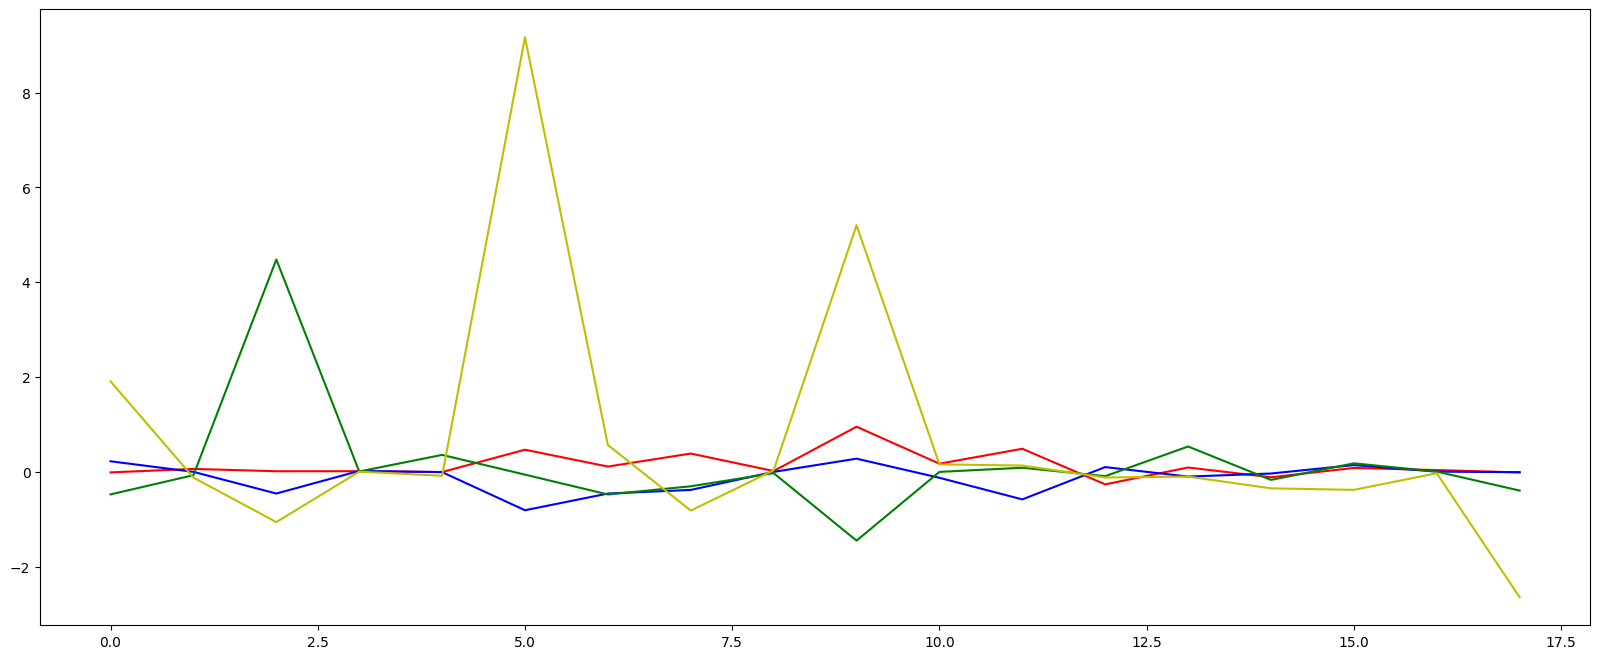

In [67]:
plt.plot(t,positives_slopes, 'r') # plotting t, a separately 
plt.plot(t,negatives_slopes, 'b') # plotting t, b separately 
plt.plot(t,baselines_slopes_fisrt, 'g') # plotting t, c separately 
plt.plot(t,baselines_slopes_last, 'y') # plotting t, c separately 
plt.show()

In [63]:
for i,p in baselines_last.groupby(by='Participant'):
    print(i)

C1K4L9S8
D0P7X9W6
G2Y7J4Q1
G9K4W1Z0
I8L4N6G7
J4X1T0D2
J6W7Q4H5
K4G7Y9O2
L0S1Z2I3
M0R6U5F9
M4H6R2W9
M7D3F5K4
N7P5B8G0
O4A0U8R1
U6O5V2T9
V9L0P2K7
X5Q0G4J2
Z6A2W1E8


Shapiro-Wilk test for Baseline_1: statistic=0.576, p=0.000
  Baseline_1 is not normally distributed (p < 0.05)
Shapiro-Wilk test for Baseline_2: statistic=0.666, p=0.000
  Baseline_2 is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive: statistic=0.827, p=0.004
  Positive is not normally distributed (p < 0.05)
Shapiro-Wilk test for Negative: statistic=0.894, p=0.046
  Negative is not normally distributed (p < 0.05)

Doing Wilcoxon
Wilcoxon Baseline_1 vs Baseline_2: statistic=80.000, p=0.832
Wilcoxon Baseline_1 vs Positive: statistic=51.000, p=0.142
Wilcoxon Baseline_1 vs Negative: statistic=78.000, p=0.766
Wilcoxon Baseline_2 vs Positive: statistic=70.000, p=0.523
Wilcoxon Baseline_2 vs Negative: statistic=83.000, p=0.932
Wilcoxon Positive vs Negative: statistic=41.000, p=0.054


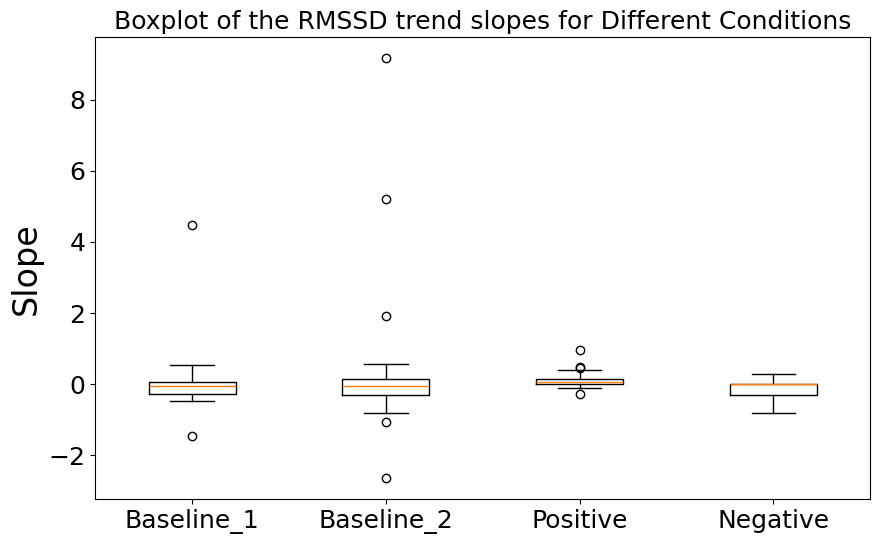

In [151]:
import pandas as pd
import numpy as np
from scipy import stats
import pingouin as pg
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 6] 


np.random.seed(42)  # For reproducibility
n_participants = len(baselines_slopes_fisrt)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline_1': baselines_slopes_fisrt,  
    'Baseline_2': baselines_slopes_last,  
    'Positive': positives_slopes,
    'Negative': negatives_slopes
}
df = pd.DataFrame(data)

# Long format for repeated measures ANOVA
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='Slope')
ps = []

# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    ps.append(p >= 0.05)
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

print()

# 2. Choose and run the test
if all(ps):  # All normal
    print('Doing anova')
    # Repeated Measures ANOVA
    anova = pg.rm_anova(data=df_long, dv='Slope', within='Condition', subject='Participant')
    print("\nRepeated Measures ANOVA Results:")
    print(anova)
    if anova['p-unc'][0] < 0.05:
        print("Significant difference found (p < 0.05). Performing post-hoc tests...")
        # Post-hoc paired t-tests with Bonferroni correction
        conditions = df.columns[1:]
        for i in range(len(conditions)):
            for j in range(i + 1, len(conditions)):
                cond1, cond2 = conditions[i], conditions[j]
                t_stat, p_val = stats.ttest_rel(df[cond1], df[cond2])
                p_adjusted = p_val * len(conditions) * (len(conditions) - 1) / 2  # Bonferroni
                print(f"Paired t-test {cond1} vs {cond2}: t={t_stat:.3f}, p={p_val:.3f}, adjusted p={p_adjusted:.3f}")
else:
    print('Doing Wilcoxon')
    # Friedman Test (non-parametric)
    #stat, p = stats.friedmanchisquare(df['Baseline_1'],df['Baseline_2'], df['Positive'], df['Negative'])
    #print("\nFriedman Test Results:")
    #print(f"Chi-square={stat:.3f}, p={p:.3f}")
    #if p <= 0.05:
        # print("Significant difference found (p < 0.05). Performing post-hoc Wilcoxon tests...")
    # Post-hoc Wilcoxon Signed-Rank tests with Bonferroni correction
    conditions = df.columns[1:]
    for i in range(len(conditions)):
        for j in range(i + 1, len(conditions)):
            cond1, cond2 = conditions[i], conditions[j]
            stat, p_val = stats.wilcoxon(df[cond1], df[cond2])
            print(f"Wilcoxon {cond1} vs {cond2}: statistic={stat:.3f}, p={p_val:.3f}")

# Optional: Visualize the data
plt.boxplot([df['Baseline_1'],df['Baseline_2'], df['Positive'], df['Negative']], tick_labels=['Baseline_1', 'Baseline_2', 'Positive', 'Negative'])
plt.title('Boxplot of the RMSSD trend slopes for Different Conditions', fontsize=18)
plt.ylabel('Slope', fontsize=24)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()


In [152]:
from scipy.stats import wilcoxon
res = wilcoxon(negatives_slopes, positives_slopes)
res.statistic, res.pvalue

(np.float64(41.0), np.float64(0.05385589599609375))

/var/folders/f1/w7d0x47j0qq9jn7k7vhjrkzh0000gn/T/ipykernel_8598/2702270380.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Condition', y='Slope', data=df_long, palette='pastel')


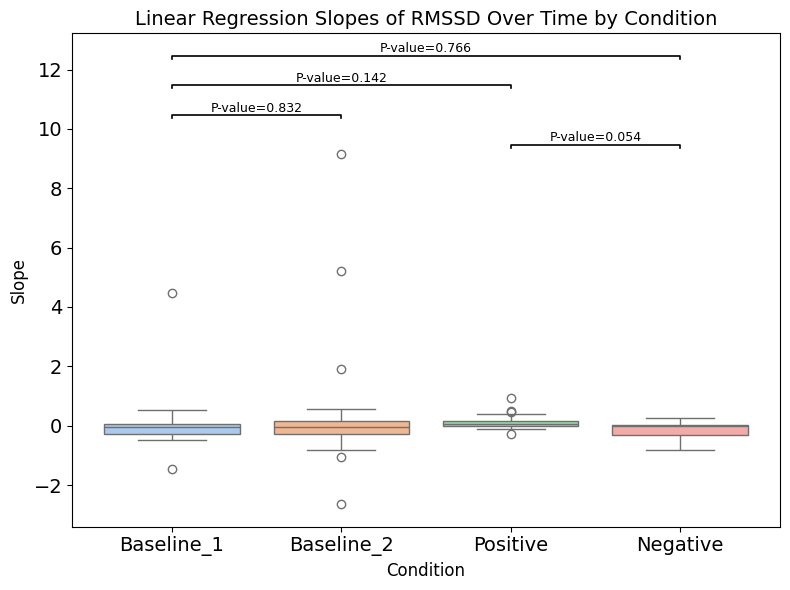

In [193]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon


# Melt data to long format
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='Slope')

# Initialize plot
plt.figure(figsize=(8, 6))
sns.boxplot(x='Condition', y='Slope', data=df_long, palette='pastel')


comparisons = [
    ('Positive', 'Negative'),
    ('Baseline_1', 'Baseline_2'),
    ('Baseline_1', 'Positive'),
    ('Baseline_1', 'Negative'),
]


x_labels = df_long['Condition'].unique().tolist()


y_offset = 1
y_start = df_long['Slope'].max() + 0.2  # Leave space above highest point
h = 0.1  # Height of bracket
fontsize = 9


for i, (cond1, cond2) in enumerate(comparisons):
    data1 = df[cond1]
    data2 = df[cond2]
    stat, p_val = wilcoxon(data1, data2)

    x1 = x_labels.index(cond1)
    x2 = x_labels.index(cond2)
    y = y_start + i * y_offset

    # Bracket
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c='k')

    # Text label
    label =  f'P-value={round(p_val,3)}'
    plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize)

# Final plot styling
plt.title('Linear Regression Slopes of RMSSD Over Time by Condition', fontsize=14)
plt.ylabel('Slope', fontsize=12)
plt.xlabel('Condition', fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()


# EDA biopac

## Questions to Martin + in signal_frequency_analysis_biopac_EDA.py

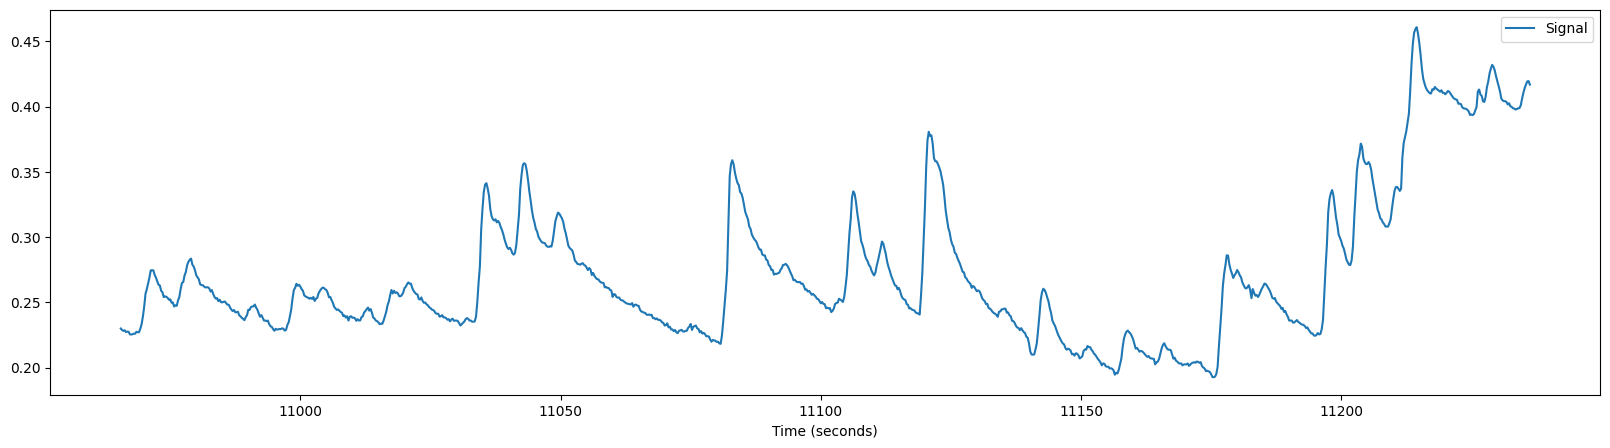

In [258]:
plt.rcParams['figure.figsize'] = [20, 5] 
raw_signal = positives.query('Participant=="Z6A2W1E8"').EDA  #I8L4N6G7
nk.signal_plot(raw_signal, sampling_rate=sampling_rate)

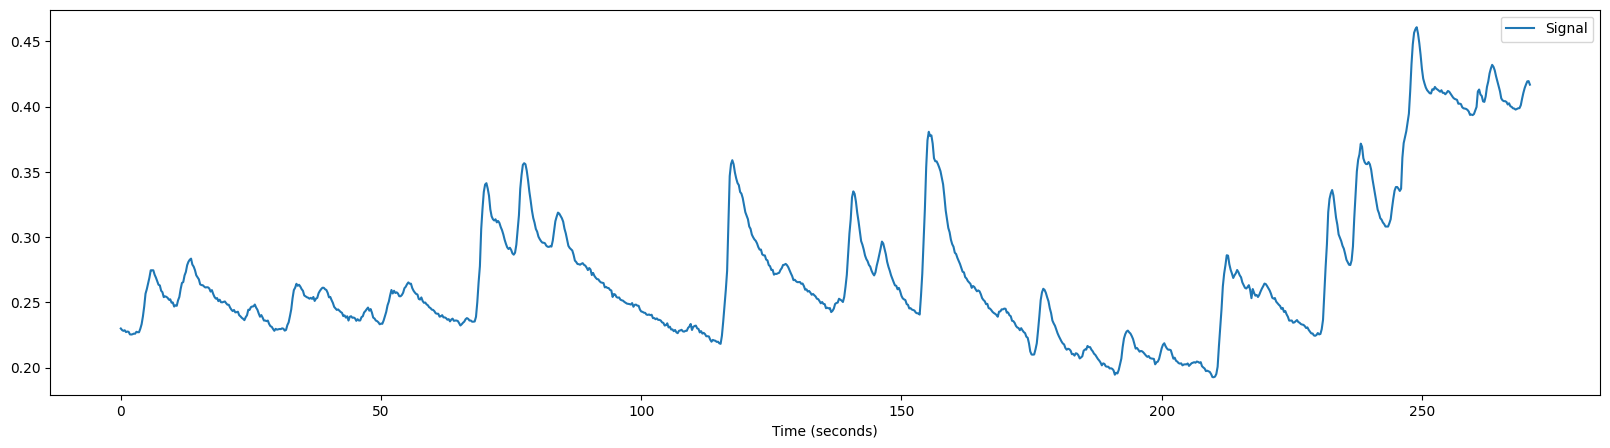

In [259]:
clean_signal = nk.eda_clean(raw_signal, sampling_rate=sampling_rate)
nk.signal_plot( clean_signal, sampling_rate=sampling_rate)

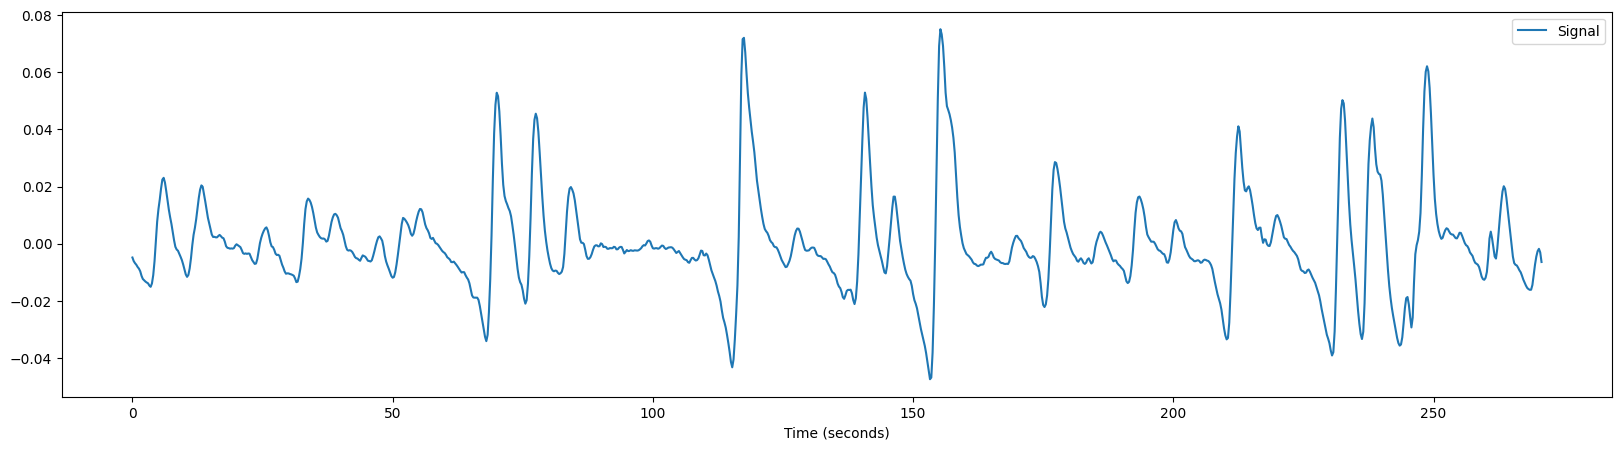

In [262]:
import neurokit2 as nk
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 5] 


# Apply a 1st-order low-pass Butterworth filter with a 1 Hz cutoff, 1st-order high-pass Butterworth filter with a 0.05 Hz cutoff
eda_filtered = nk.signal_filter(raw_signal, sampling_rate=sampling_rate, lowcut=0.05, highcut=1, order=1, method='butterworth')

nk.signal_plot(eda_filtered, sampling_rate=sampling_rate)

In [263]:
plt.rcParams['figure.figsize'] = [30, 30]  # Bigger images

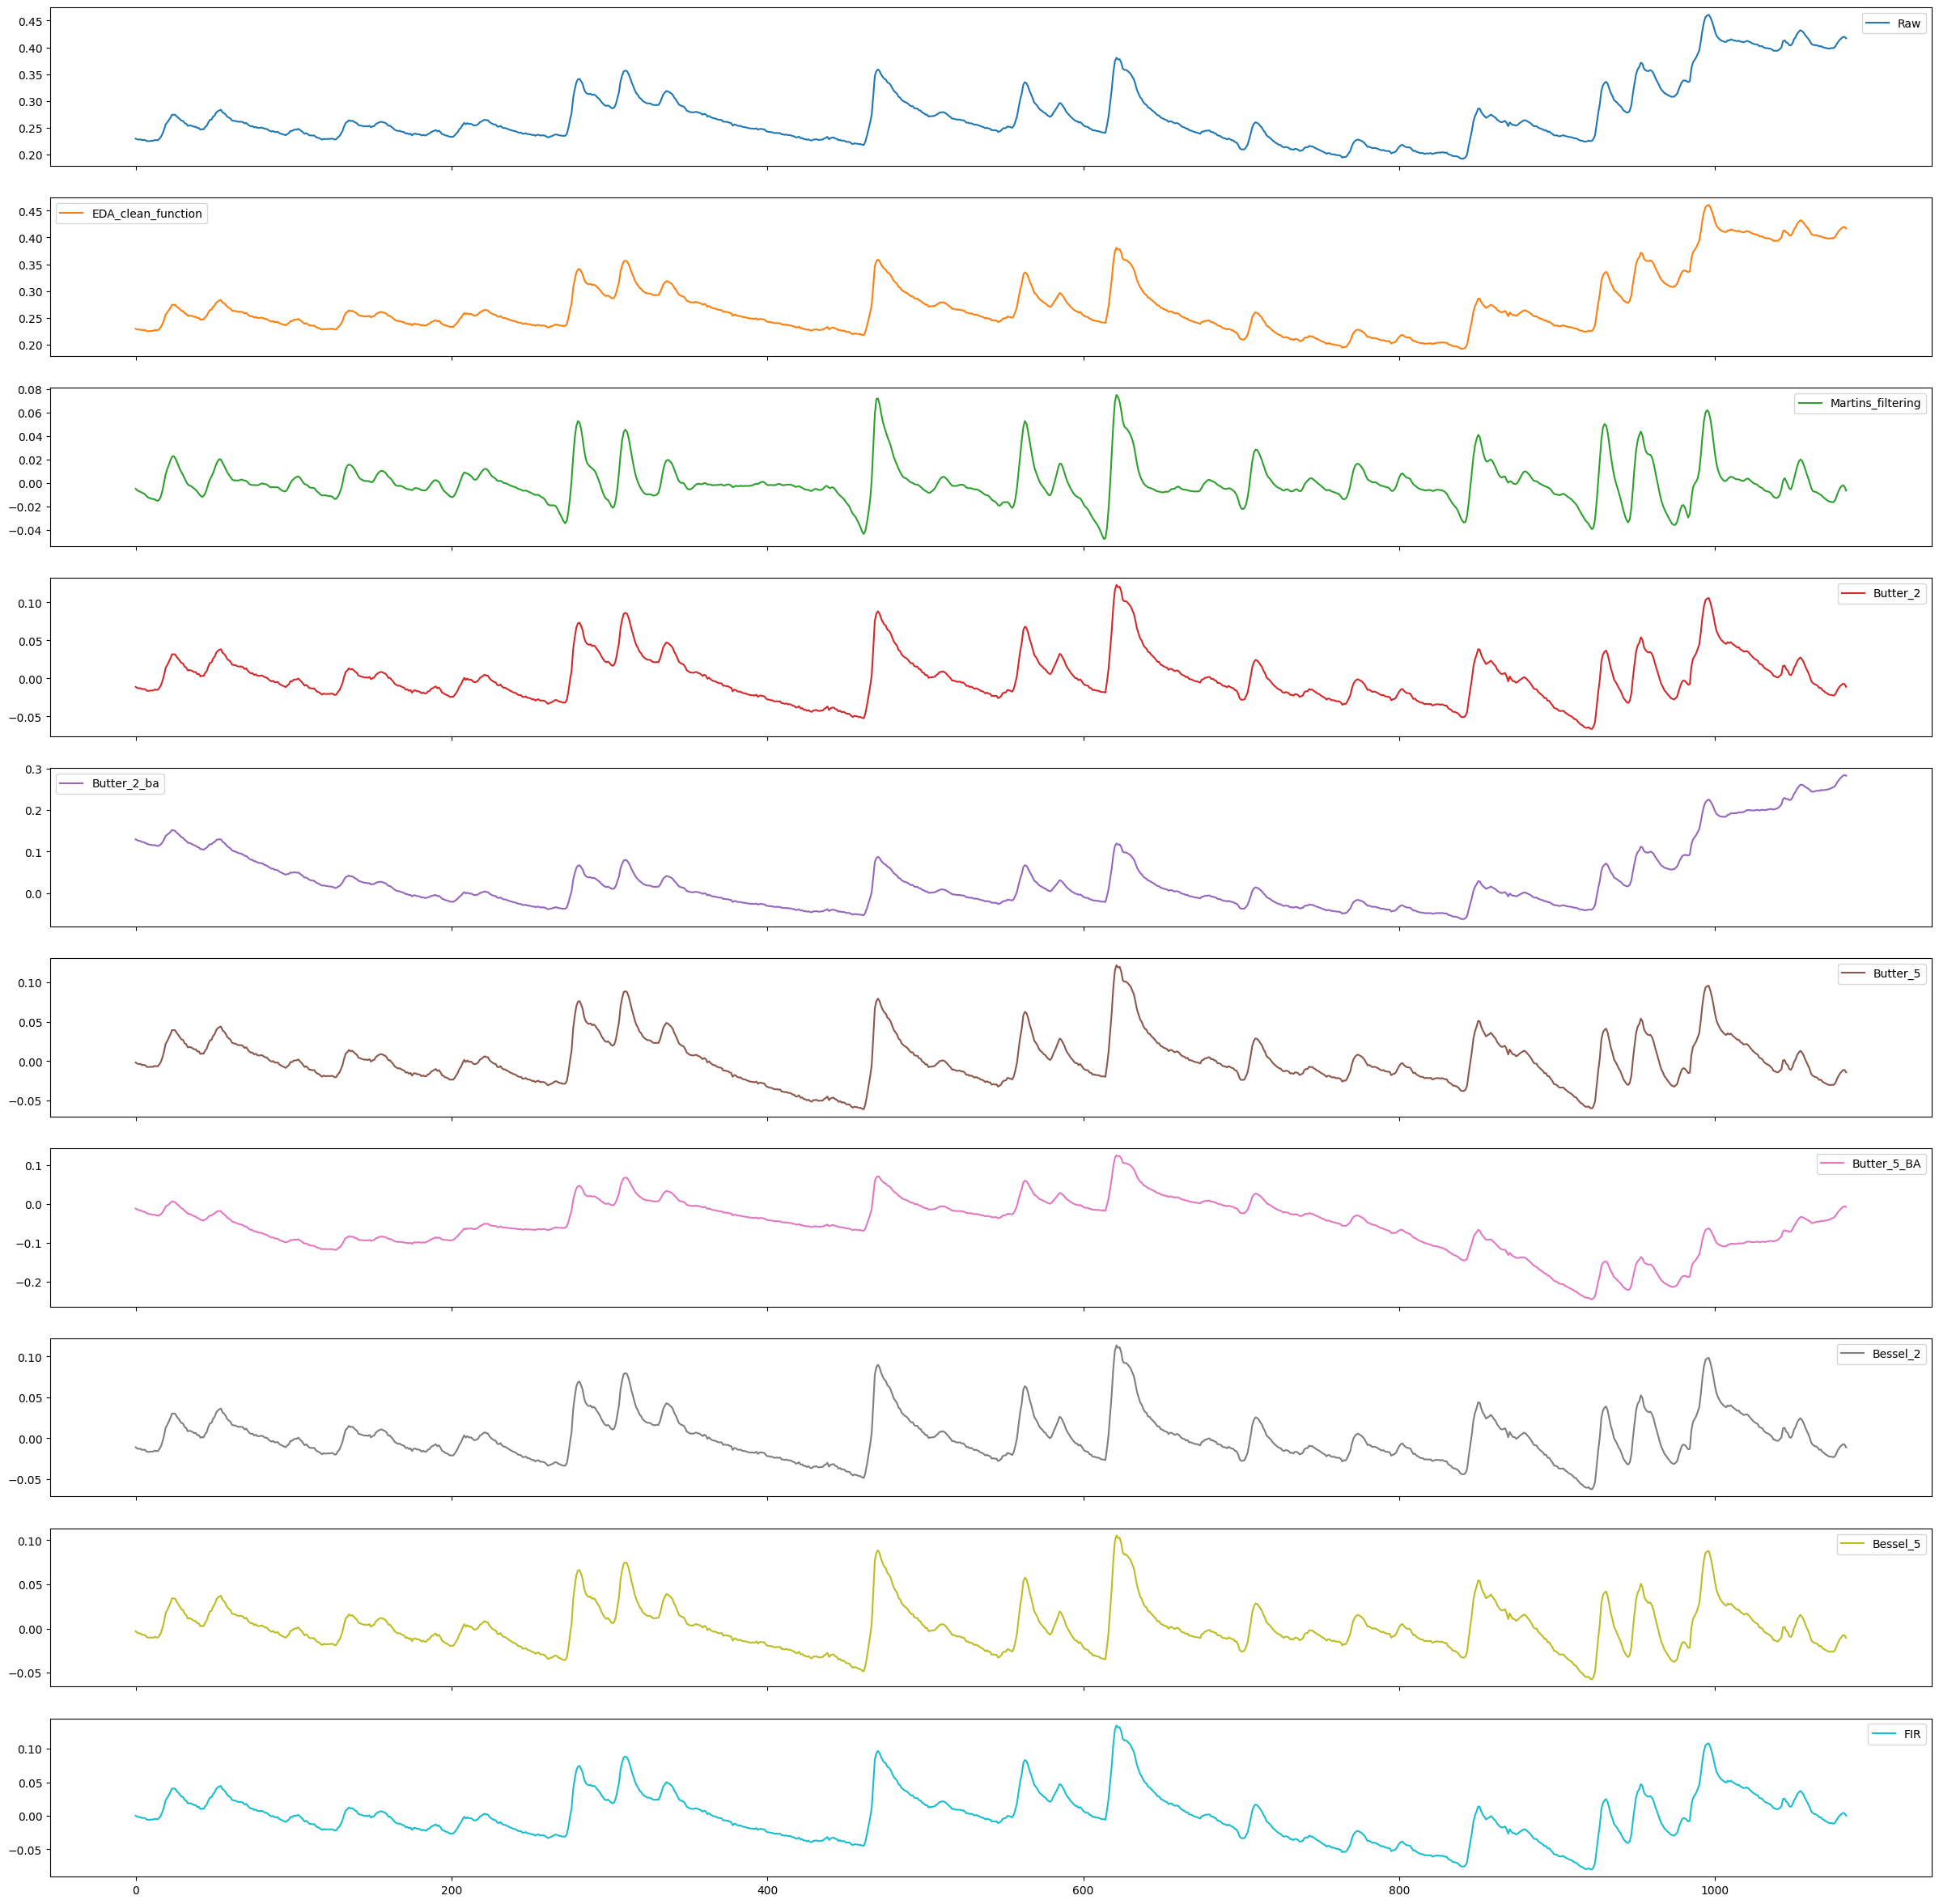

In [265]:
# Visualize Highpass Filtered Signal using Different Methods
signal = list(raw_signal)
fig2 = pd.DataFrame({"Raw": signal,
        'EDA_clean_function':  clean_signal,  
        'Martins_filtering':  eda_filtered,      
        "Butter_2": nk.signal_filter(signal, lowcut=2, method="butterworth",
        order=2),
        "Butter_2_ba": nk.signal_filter(signal, lowcut=2,
        method="butterworth_ba", order=2),
        "Butter_5": nk.signal_filter(signal, lowcut=2, method="butterworth",
        order=5),
        "Butter_5_BA": nk.signal_filter(signal, lowcut=2,
        method="butterworth_ba", order=5),
        "Bessel_2": nk.signal_filter(signal, lowcut=2, method="bessel", order=2),
        "Bessel_5": nk.signal_filter(signal, lowcut=2, method="bessel", order=5),
        "FIR": nk.signal_filter(signal, lowcut=2, method="fir")}).plot(subplots=True)


In [ ]:
plt.rcParams['figure.figsize'] = [20, 5] 
eda_biopac_filtered = pd.read_csv('/Users/annapalatkina/Desktop/drive/download.csv')
# above are only positives - here is full experiment
eda_biopac_filtered

,Time,EDA,Filtered
0,0.000,1.742249,1.394299
1,0.005,1.745605,1.574812
2,0.010,1.745300,1.068490
3,0.015,1.744995,1.112997
4,0.020,1.744690,0.804487
...,...,...,...
179995,899.975,1.620789,0.000010
179996,899.980,1.620178,-0.000405
179997,899.985,1.620483,-0.000290
179998,899.990,1.619873,-0.000532


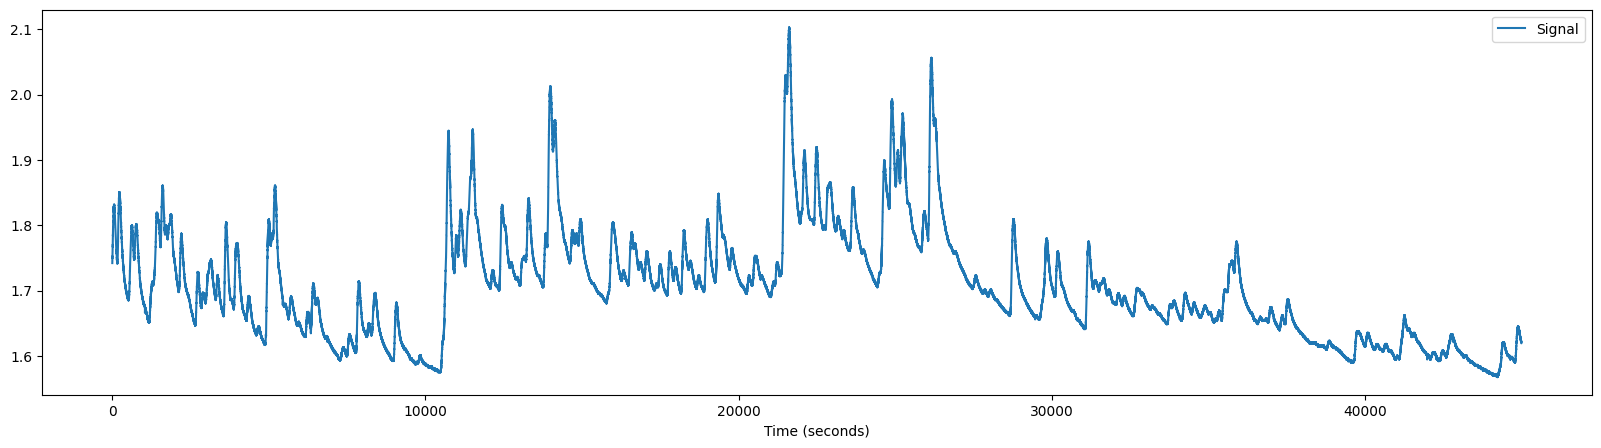

In [270]:
nk.signal_plot(eda_biopac_filtered.EDA, sampling_rate=sampling_rate)

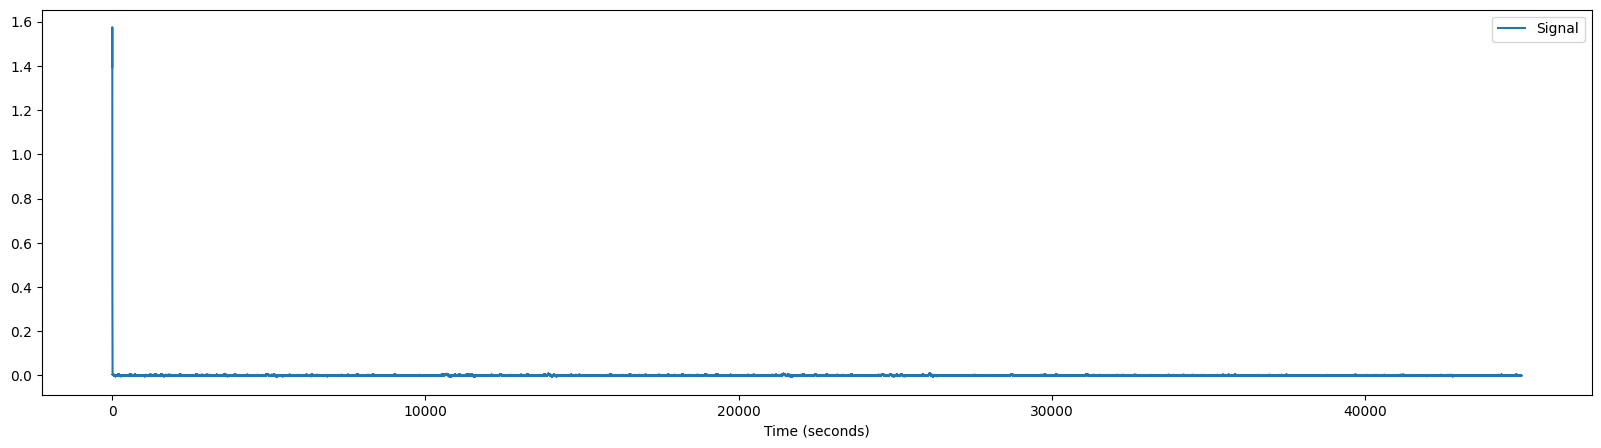

In [271]:
nk.signal_plot(eda_biopac_filtered.Filtered, sampling_rate=sampling_rate)

## EDA tests

# EDA empatica

In [208]:
df = pd.read_csv('/Users/annapalatkina/Desktop/drive/stress_output_eda_embracePlus.csv')
problematic = ['R0V9G1L4-3YK3K151PX', 'L1N3B5O2-3YK3K151PX']
df = df.query('ParticipantID not in @problematic')
df['ParticipantID'].replace('V9LOP2K7-3YK3K151PX', 'V9L0P2K7-3YK3K151PX', inplace=True)

df

,ParticipantID,file_name,samplingFrequencyEDA,time_iso,EDA,detectedMOS,MOS_Score
0,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:54.171413+00:00,0.101990,0.0,0.0
1,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:54.421413+00:00,0.127179,0.0,0.0
2,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:54.671413+00:00,0.132416,0.0,0.0
3,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:54.921413+00:00,0.134792,0.0,0.0
4,C1K4L9S8-3YK3K151PX,1-1-C1K4L9S8_1748349053.avro,4.000311,2025-05-27 12:30:55.171413+00:00,0.136614,0.0,0.0
...,...,...,...,...,...,...,...
145051,Z6A2W1E8-3YK3K151PX,1-1-112212122121_1748004502.avro,4.000284,2025-05-23 13:17:05.015978+00:00,0.957719,0.0,0.0
145052,Z6A2W1E8-3YK3K151PX,1-1-112212122121_1748004502.avro,4.000284,2025-05-23 13:17:05.265978+00:00,0.956452,0.0,0.0
145053,Z6A2W1E8-3YK3K151PX,1-1-112212122121_1748004502.avro,4.000284,2025-05-23 13:17:05.515978+00:00,0.954958,0.0,0.0
145054,Z6A2W1E8-3YK3K151PX,1-1-112212122121_1748004502.avro,4.000284,2025-05-23 13:17:05.765978+00:00,0.952368,0.0,0.0


In [209]:
def get_experiment_start(path):

    with open(path, 'r+') as f:
        for line in f.readlines():
            if line.startswith('#Recording time'):
                timestamp_str = line.replace('#Recording time,Date: ', '')
                timestamp_str = timestamp_str[:timestamp_str.find(',Unix time:')]
                break

    try:
        ts = pd.to_datetime(timestamp_str,
                        format="%d.%m.%Y,Time: %H:%M:%S.%f +02:00")
    except:
        ts = pd.to_datetime(timestamp_str,
                            format="%m/%d/%Y,Time: %H:%M:%S.%f +02:00")
    ts = ts - timedelta(hours=2)
    nanoseconds = int(ts.value)
    return nanoseconds

In [210]:
import warnings
warnings.filterwarnings('ignore')

In [212]:
folder_path = "/Users/annapalatkina/Desktop/drive/participants"  

data_full = pd.DataFrame(columns=['miliseconds', 'EDA',  'EventLabel', 'Participant', 'detectedMOS', 'MOS_Score'])

for filename in os.listdir(folder_path):
    file_path = os.path.join(folder_path, filename)  
    if filename.endswith('.csv') and filename != 'N7P5B8G0.csv': 
        print(filename)
        experiment_start_nanoseconds = get_experiment_start(file_path)
        participant_id = filename.split('.')[0]
        data_imotions = pd.read_csv(file_path, comment='#',low_memory=False, usecols=['Row','Timestamp','MarkerName','MarkerType'])
        participant_id_empatica = participant_id + '-3YK3K151PX'
        data_empatica = df.query('ParticipantID == @participant_id_empatica')
        print(len(data_imotions),len(data_empatica))
        
        data_empatica['miliseconds'] = [(pd.to_datetime(i).value - experiment_start_nanoseconds) / (10**6) for i in data_empatica['time_iso']]
        data_empatica = data_empatica.sort_values(by='miliseconds')

        start = data_imotions.query('MarkerName == "Experiment" and MarkerType == "S"').Timestamp.values[0]
        end = data_imotions.query('MarkerName == "Experiment" and MarkerType == "E"').Timestamp.values[0]
        data_empatica = data_empatica.query('@start <= miliseconds <= @end')

        markers = list(data_imotions[data_imotions['MarkerName'].notna()].sort_values('Row').MarkerName.unique())
        markers.remove('Experiment')
        data_empatica['EventLabel'] = pd.Series(dtype='object')
        for i,m in enumerate(markers):
            start = data_imotions[(data_imotions.MarkerName == m) & (data_imotions.MarkerType == "S")].Timestamp.values[0]
            end = data_imotions[(data_imotions.MarkerName == m) & (data_imotions.MarkerType == "E")].Timestamp.values[0]
            idx = data_empatica.query('@start <= miliseconds <= @end').index
            data_empatica.loc[idx, 'EventLabel'] = data_empatica.loc[idx, 'EventLabel'].fillna(m)

        #data_empatica['EventLabel'] = data_empatica['EventLabel'].fillna('Silence')
        #data_empatica['Participant'] = [participant_id] * len(data_empatica)
        #data_full = pd.concat([data_full, data_empatica], ignore_index=True)


        non_nan_indices = data_empatica['EventLabel'].notna()
        first_non_nan = non_nan_indices.idxmax() 
        last_non_nan = non_nan_indices[::-1].idxmax()

        data_empatica.loc[:first_non_nan-1, 'EventLabel'] = data_empatica.loc[:first_non_nan-1, 'EventLabel'].fillna('first_silence')
        data_empatica.loc[last_non_nan+1:, 'EventLabel'] = data_empatica.loc[last_non_nan+1:, 'EventLabel'].fillna('last_silence')

        data_empatica.drop(columns=['samplingFrequencyEDA', 'file_name', 'ParticipantID'], inplace=True)
        data_empatica['Participant'] = [participant_id] * len(data_empatica)
        data_full = pd.concat([data_full, data_empatica], ignore_index=True)
        del data_empatica
        gc.collect()

I8L4N6G7.csv
386774 11184
M0R6U5F9.csv
427740 8616
D0P7X9W6.csv
342048 9384
M7D3F5K4.csv
360471 5308
O4A0U8R1.csv
381899 7320
V9L0P2K7.csv
378075 7620
G2Y7J4Q1.csv
409514 6648
M4H6R2W9.csv
408180 6884
U6O5V2T9.csv
350289 8428
G9K4W1Z0.csv
527178 7168
J6W7Q4H5.csv
425469 7240
J4X1T0D2.csv
399706 9588
Z6A2W1E8.csv
443360 6892
L0S1Z2I3.csv
256465 6812
C1K4L9S8.csv
351098 6276
X5Q0G4J2.csv
379793 5516
K4G7Y9O2.csv
402945 5664


In [213]:
data_full

,miliseconds,EDA,EventLabel,Participant,detectedMOS,MOS_Score,time_iso
0,10656.974,0.183283,first_silence,I8L4N6G7,0.0,0.00,2025-05-20 10:09:16.784974+00:00
1,10906.974,0.181575,first_silence,I8L4N6G7,0.0,0.00,2025-05-20 10:09:17.034974+00:00
2,11156.974,0.180707,first_silence,I8L4N6G7,0.0,0.00,2025-05-20 10:09:17.284974+00:00
3,11406.974,0.180892,first_silence,I8L4N6G7,0.0,0.00,2025-05-20 10:09:17.534974+00:00
4,11656.974,0.181561,first_silence,I8L4N6G7,0.0,0.00,2025-05-20 10:09:17.784974+00:00
...,...,...,...,...,...,...,...
61017,932538.052,0.007909,last_silence,K4G7Y9O2,0.0,0.00,2025-05-19 09:54:34.822052+00:00
61018,932788.052,0.008236,last_silence,K4G7Y9O2,0.0,0.00,2025-05-19 09:54:35.072052+00:00
61019,933038.052,0.007539,last_silence,K4G7Y9O2,0.0,0.25,2025-05-19 09:54:35.322052+00:00
61020,933288.052,0.008492,last_silence,K4G7Y9O2,0.0,0.00,2025-05-19 09:54:35.572052+00:00


In [214]:
data_full.EventLabel.value_counts()

EventLabel
IntenseAudio     18502
CalmAudio        18469
first_silence    14220
last_silence      6425
InterimAudio      3406
Name: count, dtype: int64

In [222]:
data_full.groupby('Participant').detectedMOS.sum()

Participant
C1K4L9S8     6.0
D0P7X9W6     6.0
G2Y7J4Q1     6.0
G9K4W1Z0     0.0
I8L4N6G7    22.0
J4X1T0D2    26.0
J6W7Q4H5    20.0
K4G7Y9O2    16.0
L0S1Z2I3    11.0
M0R6U5F9    23.0
M4H6R2W9    26.0
M7D3F5K4     4.0
O4A0U8R1     1.0
U6O5V2T9     1.0
V9L0P2K7     8.0
X5Q0G4J2     1.0
Z6A2W1E8    10.0
Name: detectedMOS, dtype: float64

In [ ]:
data_full.groupby('Participant').MOS_Score.sum()

Participant
C1K4L9S8     32.50
D0P7X9W6     98.75
G2Y7J4Q1    105.50
G9K4W1Z0     12.00
I8L4N6G7    280.75
J4X1T0D2    531.75
J6W7Q4H5    773.25
K4G7Y9O2    782.25
L0S1Z2I3    259.75
M0R6U5F9    190.50
M4H6R2W9    630.25
M7D3F5K4     12.00
O4A0U8R1    125.50
U6O5V2T9     83.25
V9L0P2K7    351.50
X5Q0G4J2      2.50
Z6A2W1E8     78.00
Name: MOS_Score, dtype: float64

In [225]:
data_full.groupby('EventLabel').detectedMOS.sum()

EventLabel
CalmAudio        51.0
IntenseAudio     59.0
InterimAudio     10.0
first_silence    47.0
last_silence     20.0
Name: detectedMOS, dtype: float64

In [224]:
data_full.groupby('EventLabel').MOS_Score.sum()

EventLabel
CalmAudio        1273.25
IntenseAudio     1308.25
InterimAudio      189.50
first_silence    1117.00
last_silence      462.00
Name: MOS_Score, dtype: float64

In [215]:
sampling_rate = 4

In [216]:
mask_silence_first = (data_full["EventLabel"] == "first_silence")
mask_silence_last = (data_full["EventLabel"] == "last_silence")
mask_negative = (data_full["EventLabel"] == "IntenseAudio")
mask_positive = (data_full["EventLabel"] == "CalmAudio")
mask_music = (data_full["EventLabel"] == "InterimAudio")

In [217]:
positives = data_full[mask_positive]
negatives = data_full[mask_negative]
baselines_first = data_full[mask_silence_first]
baselines_last = data_full[mask_silence_last]

In [234]:
positives_mos_scores = positives.groupby('Participant').MOS_Score.sum().tolist()
negatives_mos_scores = negatives.groupby('Participant').MOS_Score.sum().tolist()
baselines_first_mos_scores = baselines_first.groupby('Participant').MOS_Score.sum().tolist()
baselines_last_mos_scores= baselines_last.groupby('Participant').MOS_Score.sum().tolist()

In [235]:
from scipy.stats import wilcoxon
res = wilcoxon(positives_mos_scores, negatives_mos_scores)
res.statistic, res.pvalue

(np.float64(56.5), np.float64(0.34362479274120517))

In [236]:
wilcoxon(baselines_first_mos_scores, negatives_mos_scores)

WilcoxonResult(statistic=np.float64(37.0), pvalue=np.float64(0.0638275146484375))

In [237]:
wilcoxon(baselines_first_mos_scores, positives_mos_scores)

WilcoxonResult(statistic=np.float64(43.0), pvalue=np.float64(0.19603343437963117))

In [ ]:
wilcoxon(baselines_first_mos_scores, baselines_last_mos_scores)
# WTF?

WilcoxonResult(statistic=np.float64(5.5), pvalue=np.float64(0.0007752697776041399))

In [239]:
wilcoxon(baselines_last_mos_scores, positives_mos_scores)

WilcoxonResult(statistic=np.float64(4.0), pvalue=np.float64(0.0009350911193154888))

In [240]:
wilcoxon(baselines_last_mos_scores, negatives_mos_scores)

WilcoxonResult(statistic=np.float64(5.0), pvalue=np.float64(0.000152587890625))

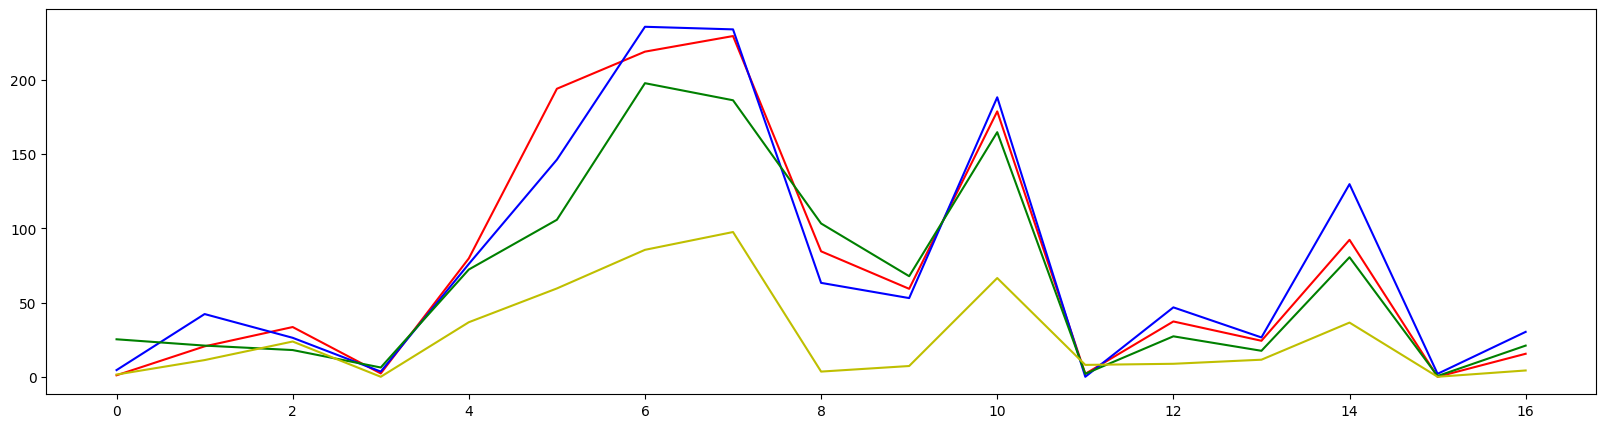

In [272]:
plt.rcParams['figure.figsize'] = [20, 5] 
plt.plot(positives_mos_scores, 'r') # plotting t, a separately 
plt.plot(negatives_mos_scores, 'b') # plotting t, b separately 
plt.plot(baselines_first_mos_scores, 'g') # plotting t, c separately 
plt.plot(baselines_last_mos_scores, 'y') # plotting t, c separately 
plt.show()

In [297]:
np.random.seed(42)  # For reproducibility
n_participants = len(positives_mos_scores)
data = {
    'Participant': list(range(1, n_participants + 1)),
    'Baseline_1': baselines_first_mos_scores,  
    'Baseline_2': baselines_last_mos_scores, 
    'Positive': positives_mos_scores,
    'Negative': negatives_mos_scores
}
df = pd.DataFrame(data)

# Long format for repeated measures ANOVA
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='Slope')
ps = []

# 1. Check normality for each condition (Shapiro-Wilk test)
for condition in df.columns[1:]:
    stat, p = stats.shapiro(df[condition])
    print(f"Shapiro-Wilk test for {condition}: statistic={stat:.3f}, p={p:.3f}")
    ps.append(p >= 0.05)
    if p < 0.05:
        print(f"  {condition} is not normally distributed (p < 0.05)")

Shapiro-Wilk test for Baseline_1: statistic=0.846, p=0.009
  Baseline_1 is not normally distributed (p < 0.05)
Shapiro-Wilk test for Baseline_2: statistic=0.807, p=0.003
  Baseline_2 is not normally distributed (p < 0.05)
Shapiro-Wilk test for Positive: statistic=0.824, p=0.004
  Positive is not normally distributed (p < 0.05)
Shapiro-Wilk test for Negative: statistic=0.835, p=0.006
  Negative is not normally distributed (p < 0.05)


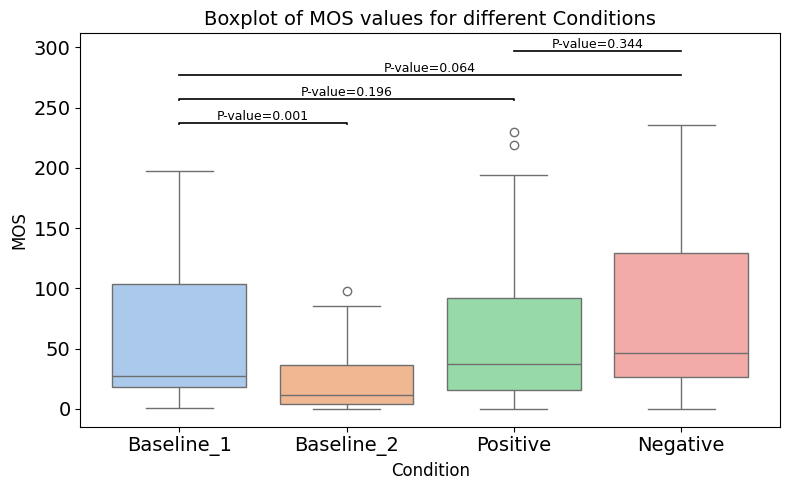

In [298]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon


# Melt data to long format
df_long = pd.melt(df, id_vars=['Participant'], var_name='Condition', value_name='MOS')

# Initialize plot
plt.figure(figsize=(8, 5))
sns.boxplot(x='Condition', y='MOS', data=df_long, palette='pastel')


comparisons = [
    ('Baseline_1', 'Baseline_2'),
    ('Baseline_1', 'Positive'),
    ('Baseline_1', 'Negative'),
    ('Positive', 'Negative')
]


x_labels = df_long['Condition'].unique().tolist()


y_offset = 20
y_start = df_long['MOS'].max() + 1  # Leave space above highest point
h = 0.1  # Height of bracket
fontsize = 9


for i, (cond1, cond2) in enumerate(comparisons):
    data1 = df[cond1]
    data2 = df[cond2]
    stat, p_val = wilcoxon(data1, data2)

    x1 = x_labels.index(cond1)
    x2 = x_labels.index(cond2)
    y = y_start + i * y_offset

    # Bracket
    plt.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.2, c='k')

    # Text label
    label =  f'P-value={round(p_val,3)}'
    plt.text((x1 + x2) * 0.5, y + h + 0.01, label, ha='center', va='bottom', fontsize=fontsize)

# Final plot styling
plt.title('Boxplot of MOS values for different Conditions', fontsize=14)
plt.ylabel('MOS', fontsize=12)
plt.xlabel('Condition', fontsize=12)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()
